In [18]:
pip -q install ruptures scikit-learn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import ruptures as rpt

## Feature Extraction

In [20]:
def statistical_features(arr):
    vmin = np.amin(arr)
    vmax = np.amax(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return vmin, vmax, mean, std

def shape_features(arr):
    skewness = skew(arr)
    kurt = kurtosis(arr)
    return skewness, kurt

In [21]:
user = 'DF'

## Pre-processing

In [22]:
import_path = f'{user}'
export_path = f'{user}'

rightEDAdatapath  = f'{import_path}/EDA.csv'
rightHRdatapath   = f'{import_path}/HR.csv'
rightTEMPdatapath = f'{import_path}/TEMP.csv'

In [23]:
rightHRdatapath = np.loadtxt(rightHRdatapath, delimiter = ',')
rightHRdatapath = np.repeat(rightHRdatapath, 4)
np.savetxt('hr_new.csv', rightHRdatapath, delimiter = ',')

In [24]:
edat =  pd.read_csv(f'{user}/EDA.csv',  header = 2,  names = ['EDA'])
hrt =   pd.read_csv(f'hr_new.csv',      header = 12, names = ['HR'])
tempt = pd.read_csv(f'{user}/TEMP.csv', header = 2,  names = ['TEMP'])
gt =    pd.read_csv(f'{user}/EDA.csv',  nrows  = 1)

In [25]:
reference_time = gt.iloc[0,0]
min_len = min(len(edat), len(hrt), len(tempt))

eda = edat.iloc[:min_len, 0]
hrt = hrt.iloc[:min_len, 0]
tempt = tempt.iloc[:min_len, 0]
df_original = pd.concat([eda, hrt, tempt], axis = 1)

In [26]:
array = df_original.values
data = pd.DataFrame(array)
data.columns = ['EDA','HR','temp']

cols = [
    'EDA_Mean','EDA_Min','EDA_Max','EDA_Std', 'EDA_Kurtosis', 'EDA_Skew','EDA_Num_Peaks','EDA_Amphitude','EDA_Duration',
    'HR_Mean','HR_Min','HR_Max','HR_Std','HR_RMS','temp_Mean', 'temp_Min','temp_Max','temp_Std'
]
df_features = pd.DataFrame(columns=cols)

index = 0

for i in range(0,len(data['EDA']), 20):
    df_partial = data.iloc[i:i+40,]
    plen = len(df_partial['EDA'])
    
    if plen < 40:
        continue
    
    eda = df_partial['EDA'].values
    hr = df_partial['HR'].values
    temp = df_partial['temp'].values

    eda_min, eda_max, eda_mean, eda_std = statistical_features(eda)
    hr_min, hr_max, hr_mean, hr_std = statistical_features(hr)
    temp_min, temp_max, temp_mean, temp_std = statistical_features(temp)
    eda_skew, eda_kurtosis = shape_features(eda)
    
    hr_rms = np.sqrt(np.mean(np.square(np.ediff1d(hr))))
    temp_rms= np.sqrt(np.mean(np.square(np.ediff1d(temp))))

    peaks,properties = find_peaks(eda, width=5)
    num_Peaks = len(peaks)
    
    prominences = np.array(properties['prominences'])
    widths = np.array(properties['widths'])
    amphitude = np.sum(prominences)
    duration = np.sum(widths)

    df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amphitude, duration, hr_mean, hr_min, hr_max, hr_std,hr_rms, temp_mean, temp_min, temp_max, temp_std]

    index = index+1

In [27]:
cols = list(map(str, range(30, 0, -1)))
df_lag_features = pd.DataFrame(columns=cols)
df_lag_features = pd.concat([
    df_features['HR_Mean'].shift(10),  df_features['HR_Mean'].shift(9),    df_features['HR_Mean'].shift(8),
    df_features['HR_Mean'].shift(7),   df_features['HR_Mean'].shift(6),    df_features['HR_Mean'].shift(5),
    df_features['HR_Mean'].shift(4),   df_features['HR_Mean'].shift(3),    df_features['HR_Mean'].shift(2),
    df_features['HR_Mean'].shift(1),   df_features['temp_Mean'].shift(10), df_features['temp_Mean'].shift(9),
    df_features['temp_Mean'].shift(8), df_features['temp_Mean'].shift(7),  df_features['temp_Mean'].shift(6),
    df_features['temp_Mean'].shift(5), df_features['temp_Mean'].shift(4),  df_features['temp_Mean'].shift(3),
    df_features['temp_Mean'].shift(2), df_features['temp_Mean'].shift(1),  df_features['EDA_Mean'].shift(10),
    df_features['EDA_Mean'].shift(9),  df_features['EDA_Mean'].shift(8),   df_features['EDA_Mean'].shift(7),
    df_features['EDA_Mean'].shift(6),  df_features['EDA_Mean'].shift(5),   df_features['EDA_Mean'].shift(4),
    df_features['EDA_Mean'].shift(3),  df_features['EDA_Mean'].shift(2),   df_features['EDA_Mean'].shift(1)], axis=1)
df_lag_features.columns = cols
df_lag_features = df_lag_features.dropna()

In [36]:
df_temp = df_features.iloc[30:3238, 0:31]
df_total = pd.concat([df_lag_features, df_temp], axis=1)
print(df_total)

            30        29        28        27        26        25        24  \
10    73.55725  73.54675  74.86250  74.94125  74.37750  74.13025  73.99975   
11    73.54675  74.86250  74.94125  74.37750  74.13025  73.99975  73.82150   
12    74.86250  74.94125  74.37750  74.13025  73.99975  73.82150  73.10025   
13    74.94125  74.37750  74.13025  73.99975  73.82150  73.10025  71.97175   
14    74.37750  74.13025  73.99975  73.82150  73.10025  71.97175  70.93975   
...        ...       ...       ...       ...       ...       ...       ...   
1140  66.89550  65.61350  64.33075  62.91675  61.92000  61.83200  62.51950   
1141  65.61350  64.33075  62.91675  61.92000  61.83200  62.51950  63.36325   
1142  64.33075  62.91675  61.92000  61.83200  62.51950  63.36325  64.12100   
1143  62.91675  61.92000  61.83200  62.51950  63.36325  64.12100  64.77550   
1144  61.92000  61.83200  62.51950  63.36325  64.12100  64.77550  65.39425   

            23        22        21  ...  EDA_Duration   HR_Mean

## Stress detection model

In [29]:
df_lag = pd.read_csv('combined_lagEDA.csv')
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100,max_depth=15)

# Split our data
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train, train_labels.values.ravel())

y_pred = clf.predict(test)
print(test.shape)

f1score   = f1_score        (test_labels, y_pred, average = 'macro')
recall    = recall_score    (test_labels, y_pred, average = 'macro')
precision = precision_score (test_labels, y_pred, average = 'macro')
accuracy  = accuracy_score  (test_labels, y_pred)

print('acc =', accuracy)
print('pre =', precision)
print('recall =', recall) 
print('f1 =', f1score)

(4107, 48)
acc = 0.9466764061358656
pre = 0.9473022889911188
recall = 0.9248976345623956
f1 = 0.9343787633738166


### Predicting the stress

In [30]:
df_total = df_total.dropna()
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(df_total.iloc[:,0:48])
data = pd.DataFrame(x_scaled)
data = data.fillna(0)

pred_t = clf.predict(data)
pred_t = pd.DataFrame(pred_t)
pred_t.columns=['pred']
pred_t.head(30)
pred_t.to_csv('pred'+user+'.csv')

c:\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [31]:
df_total['pred'] = pred_t
df_total.to_csv('pred{user}.csv')

In [32]:
df_total['MA_3'] = np.ceil(df_total.iloc[:,48:49].rolling(window=31).mean())

### Change detection

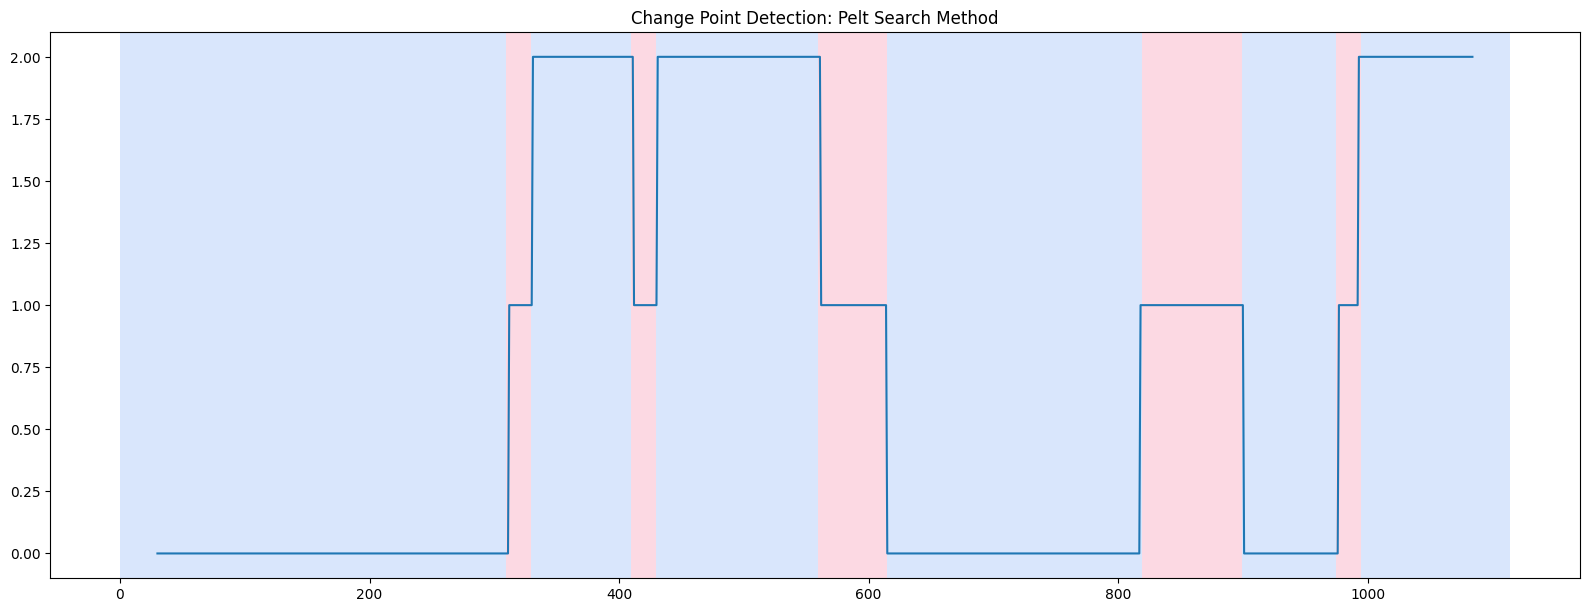

[0, 310, 330, 410, 430, 560, 615, 820, 900, 975, 995, 1115]


In [33]:
signal = df_total.iloc[:,49:50].values

algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)

rpt.display(signal, result, figsize=(16, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

result.insert(0, 0)
print(result)

### Generating the event by start and end epoch_times

In [34]:
temp_start = 0
temp_end = result[0]

stress = []
for i in range (len(result)-1):
    
    temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]
    
    if temp > 1.3:
        temp = 2.0
    elif temp >= .65:
        temp = 1
    else:
        temp = 0

    stress.append(temp)
    
df_temp = pd.DataFrame(columns=['start', 'end', 'stress'])
c = 0
for i in range(len(result)-1):
    stressLength = (result[i+1] - result[i]) / 12

    start_point  = result[i]
    end_point    = result[i + 1]
    stress_value = stress[i]
    
    if temp_end <= start_point:
        temp_end       = end_point
        df_temp.loc[c] = [start_point, end_point, stress_value]
        c = c +1

df_temp

,start,end,stress
0,0.0,310.0,0.0
1,310.0,330.0,1.0
2,330.0,410.0,2.0
3,410.0,430.0,1.0
4,430.0,560.0,2.0
5,560.0,615.0,1.0
6,615.0,820.0,0.0
7,820.0,900.0,1.0
8,900.0,975.0,0.0
9,975.0,995.0,1.0


## Change event time to datetime

In [35]:
stress_start = 0
stress_end = 0
tse = 0
previous_stress = -1

for index, row in df_temp.iterrows():

    if row['stress'] == previous_stress:
        stress_end = row['end']
    else:
        if(previous_stress != -1):
            start    = datetime.fromtimestamp(reference_time + (stress_start * 5))
            end      = datetime.fromtimestamp(reference_time + (stress_end * 5))
            timediff = end - start
            print('Prev:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)
        
        stress_start    = row['start']
        stress_end      = row['end']
        previous_stress = row['stress']
        
print('Final:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)

Prev: 0:25:50 06:00:04 06:25:54 0.0
Prev: 0:01:40 06:25:54 06:27:34 1.0
Prev: 0:06:40 06:27:34 06:34:14 2.0
Prev: 0:01:40 06:34:14 06:35:54 1.0
Prev: 0:10:50 06:35:54 06:46:44 2.0
Prev: 0:04:35 06:46:44 06:51:19 1.0
Prev: 0:17:05 06:51:19 07:08:24 0.0
Prev: 0:06:40 07:08:24 07:15:04 1.0
Prev: 0:06:15 07:15:04 07:21:19 0.0
Prev: 0:01:40 07:21:19 07:22:59 1.0
Final: 0:01:40 07:22:59 07:32:59 2.0
